### How long should people infected with the virus isolate for? Possible steps to answer this are:
- Find all terms that describe isolation (incubation, quarantine, isolation, infectious, transmissable, spreading, transferable, contagious)
- Look for all numbers used near these words (in the form 'XX days') that describe the recommend isolation period.
- Put all numbers into a list and average them to determine the recommended isolation period.
- Spot check a few examples to check it's working as expected.

In [21]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
stopwords=set(nltk.corpus.stopwords.words('english'))
from collections import defaultdict
import joblib

### Import data

In [23]:
days_to_isolate = joblib.load("outputs/isolation_results_june_5000.pkl")

In [24]:
a = np.asarray(days_to_isolate[0], dtype=np.float32)
print(f'Median recommended isolation: {np.median(a)} days')
print(f'Number of keywords found: {len(days_to_isolate[0])}')

Median recommended isolation: 10.0 days
Number of keywords found: 78


In [25]:
import matplotlib.pyplot as plt

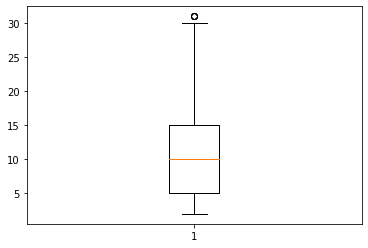

In [29]:
plt.boxplot(a)
plt.show()

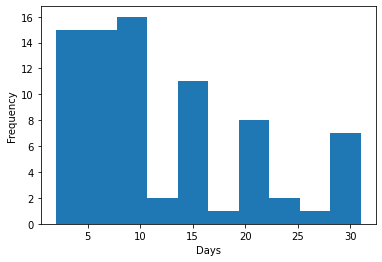

In [30]:
plt.hist(a)
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.show()

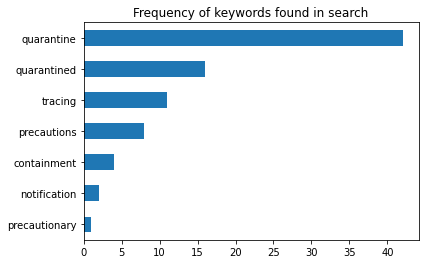

In [31]:
df = pd.DataFrame(days_to_isolate[2].items(), columns=['keyword', 'frequency'])
df = df.sort_values('frequency', ascending=True)
df.plot(x='keyword', y='frequency', kind='barh', legend=False)
plt.title('Frequency of keywords found in search')
plt.ylabel('')
plt.show()